In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ultranest
import ultranest.stepsampler as ultrastep
import pickle
import sys,os,json
sys.path.append('../')
import project.profiles as pp
from project.constants import Constants as pc

In [2]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
mwd = MW_dict.copy()

In [3]:
mw_RC = MW_dict['RC']
mw_r, mw_v, mw_e = mw_RC[:,0], mw_RC[:,1], mw_RC[:,2]

def v_plummer(logM, b, r):
    M = 10**logM
    Mr = M*(r**3/(b**2 + r**2)**(3/2))
    return np.sqrt(pc.G*Mr/r)
    
def RCmodel(params,output = 'model',r = mw_r, bulge = 'EXP'):
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = params
    rs = pp.rs_nfw(np.log10(m200)+12., c200)
    vnfw = pp.v_nfw(np.log10(m200)+12., rs, r)
    vdstar = pp.v_exp(np.log10(mdstar)+9., rdstar, r)
    vdgas = pp.v_exp(np.log10(mdgas)+9., rdgas, r)
    if bulge == 'EXP':
        vdbul = pp.v_exp(np.log10(mdbul)+9., rdbul, r)
    elif bulge == 'Plummer':
        vdbul = v_plummer(np.log10(mdbul)+9., rdbul, r)
    vmodel = np.sqrt(vnfw**2 + vdgas**2 + vdbul**2 + vdstar**2)
    if output == 'model':
        return vmodel
    elif output == 'all':
        return (vmodel, vnfw, vdstar, vdgas, vdbul)

In [4]:
param_names = list(MW_dict['fiducial_range'].keys())

ranges = [[0.1,5.0],[5.0,21.0],
          [10.0,100.0],[1.0,50.0],[1.0,100.0],
          [2.0,8.0],[0.2,2.0],[2.0, 25.0]]

def prior(cube):
    params = cube.copy()
    for i, key in enumerate(param_names):
        fid = ranges[i]
        params[i] = cube[i]*(fid[1] - fid[0]) + fid[0]
    return params

def llike(params):
    if params[7] < params[5]:
        return -1e38
    if params[6] > params[5]:
        return -1e38
    if (params[2] < params[3]) or (params[2] < params[4]):
        return -1e38
    vmodel = RCmodel(params,bulge='EXP')
    indx = np.where((mw_r >= 0))
    ll = -0.5*(((mw_v[indx] - vmodel[indx])/(mw_e[indx]))**2).sum()
    ll -= ((np.log10(params[1]) - pp.lc200_SR(np.log10(params[0])+12.0))/0.11)**2
    return ll

In [5]:
ultraroot = '../Output/Ultra/MW_RC_fit'
nsteps = 8*len(param_names)
sampler = ultranest.ReactiveNestedSampler(param_names, llike, prior,
                                          log_dir = ultraroot, 
                                          resume = 'resume')
sampler.stepsampler = ultrastep.RegionSliceSampler(nsteps = nsteps)

In [6]:
result = sampler.run()

[ultranest] Resuming from 14858 stored points
[ultranest] Widening roots to 618 live points (have 400 already) ...
[ultranest] Widening roots to 968 live points (have 618 already) ...


[ultranest] Explored until L=-8e+01  3 [-77.8209..-77.8198]*| it/evals=14453/3828032 eff=inf% N=400    0   400 00 
[ultranest] Likelihood function evaluations: 3828032
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -108.6 +- 0.1894
[ultranest] Effective samples strategy satisfied (ESS = 3350.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.


In [7]:
for i, key in enumerate(MW_dict['fiducial_range'].keys()):
    mean = result['posterior']['mean']
    fid = MW_dict['fiducial_range'][key]
    print (f'----{key}--------')
    print (f'[{fid[0]:.1f}, {mean[i]:.1f},  {fid[1]:.1f}]')

----m200--------
[0.9, 0.7,  1.6]
----c200--------
[9.0, 9.6,  17.0]
----mdstar--------
[42.0, 48.2,  63.0]
----mdbul--------
[8.0, 8.3,  20.0]
----mdgas--------
[1.0, 39.4,  20.0]
----rdstar--------
[2.0, 2.8,  4.0]
----rdbul--------
[1.9, 0.2,  2.0]
----rdgas--------
[5.0, 7.8,  20.0]


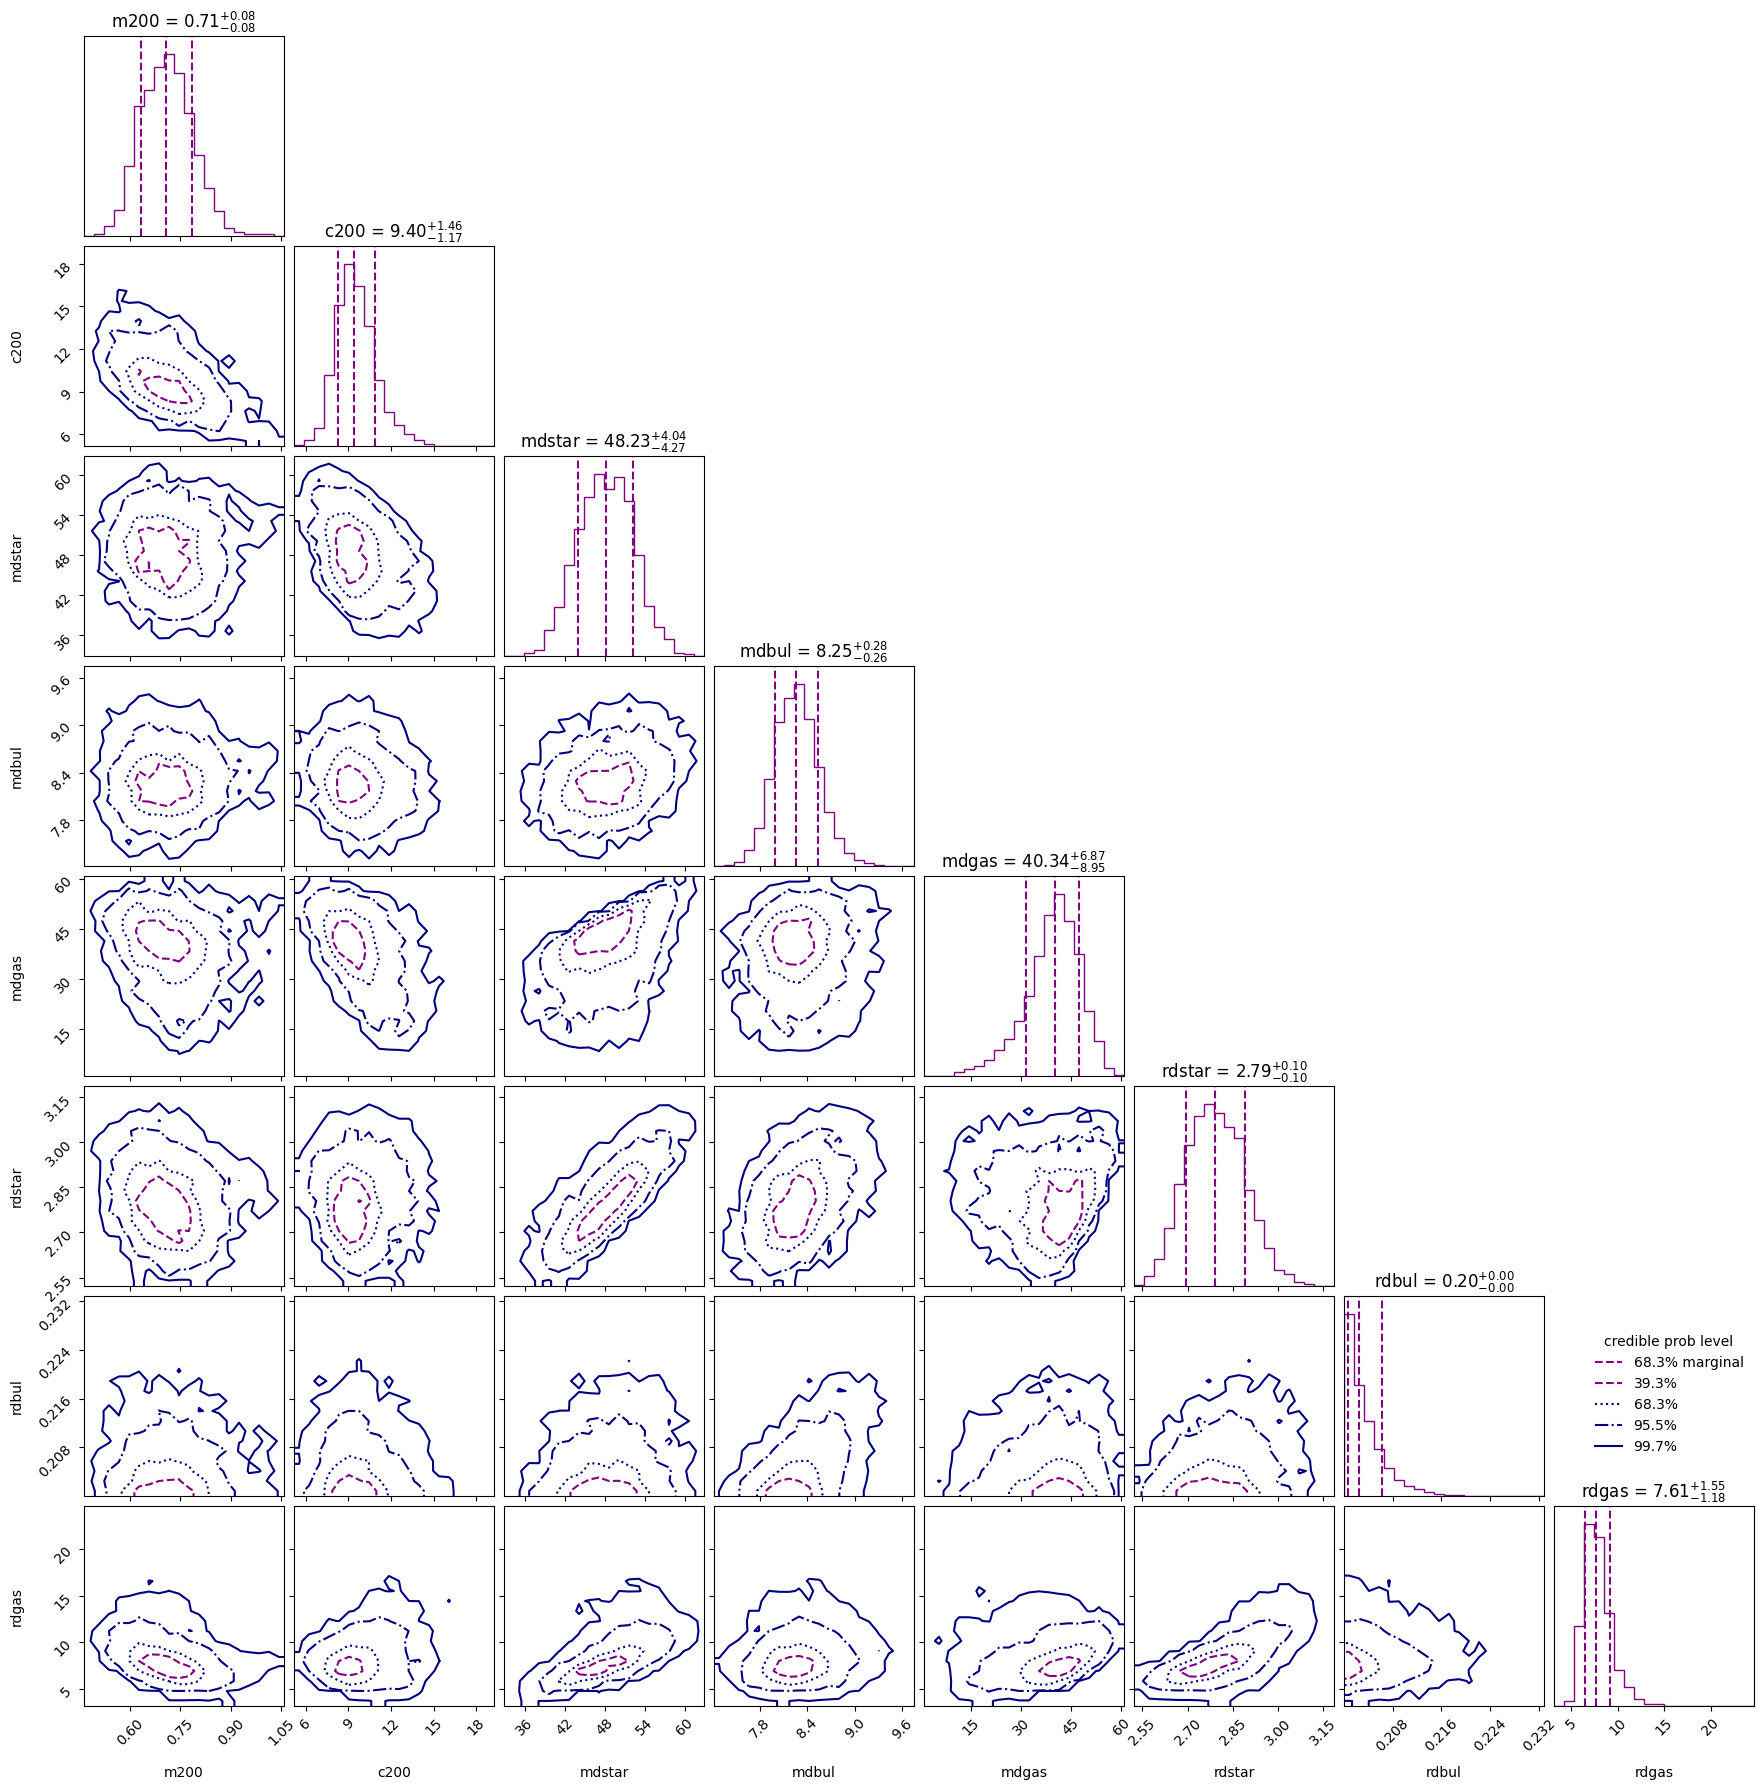

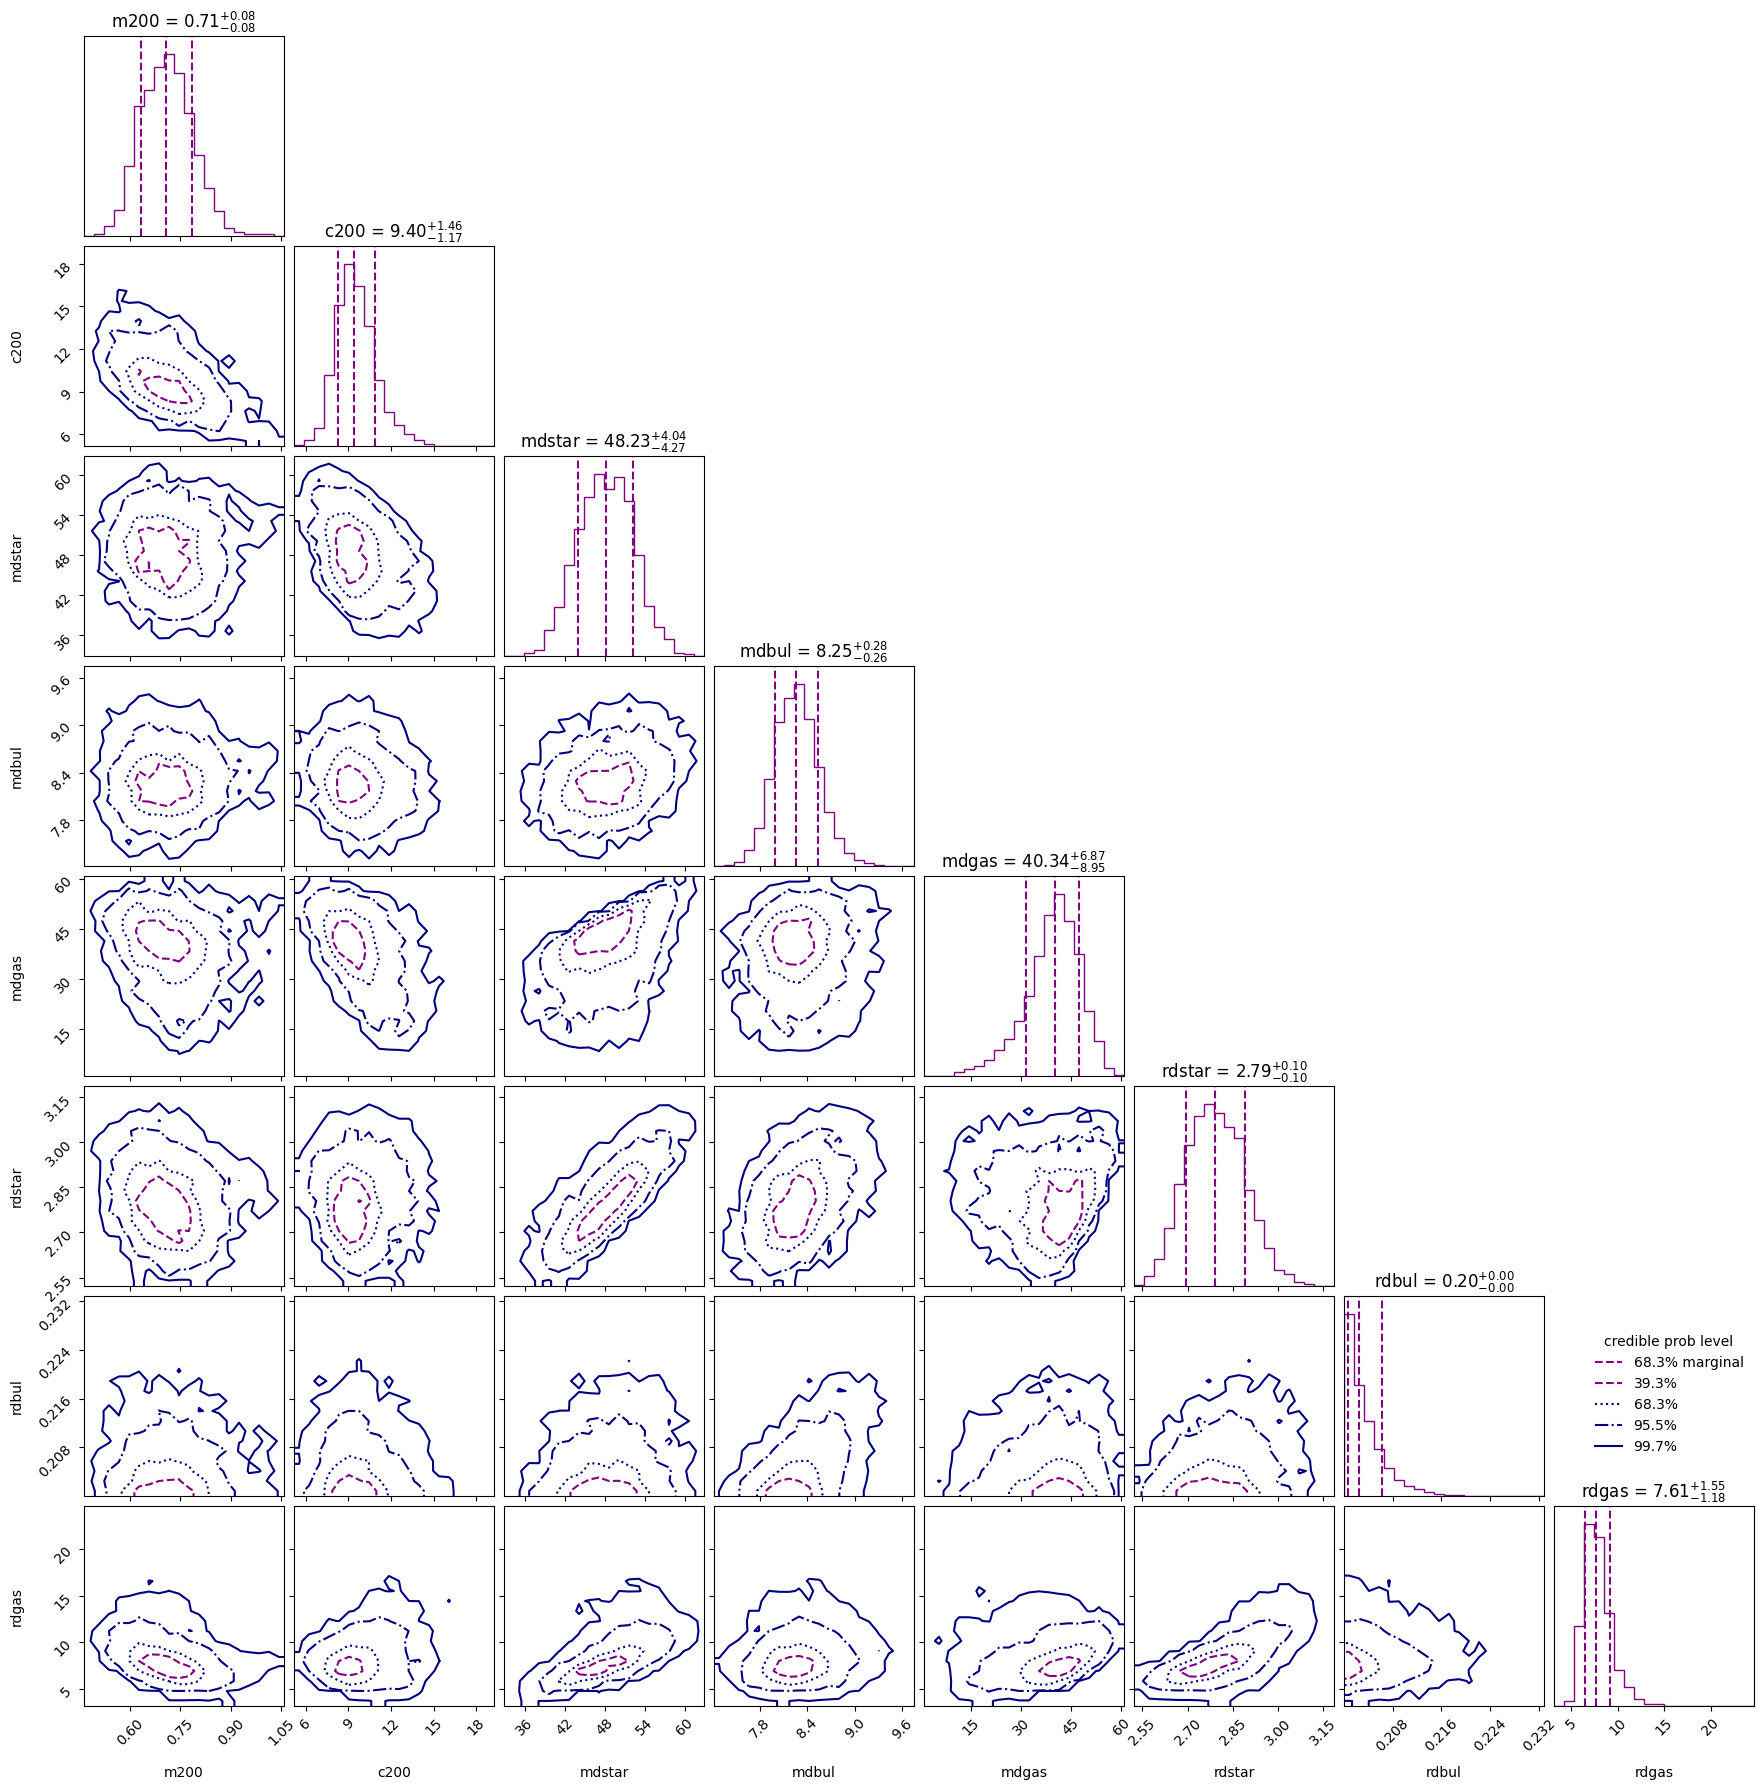

In [8]:
from ultranest.plot import cornerplot
cornerplot(result)
# plt.savefig('../Output/figures/MWfit_corner.png',bbox_inches = 'tight',dpi = 300)

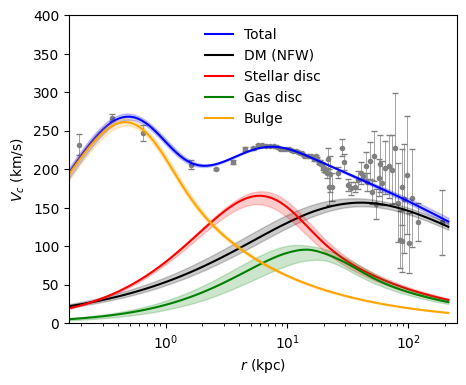

In [50]:
from ultranest.plot import PredictionBand

fig,ax = plt.subplots(figsize = (5,4))
ax.errorbar(mw_r, mw_v, mw_e, fmt = '.', elinewidth = 0.5, capsize = 2, alpha = 1, c = 'grey', zorder = 0)

names = ['Total', 'DM (NFW)', 'Stellar disc', 'Gas disc', 'Bulge']
clrs = ['b', 'k', 'r', 'g', 'orange']

R = np.logspace(-0.8,2.33,100)
bands = [PredictionBand(R) for name in names]

for params in sampler.results['samples']:
    vnames = RCmodel(params,'all',R)
    for i,band in enumerate(bands):
        band.add(vnames[i])

for i,band in enumerate(bands):
    band.line(color = clrs[i], zorder = 1, label = names[i])
    band.shade(color = clrs[i], alpha = 0.2, zorder = 1)

ax.legend(framealpha = 0)
ax.set_xscale('log')
ax.set_xlabel('$r$ (kpc)')
ax.set_ylabel('$V_c$ (km/s)')
ax.set_xlim(10**-0.8,250)
ax.set_ylim(0,400)

# plt.savefig('../Output/figures/MWRC_fit.pdf',bbox_inches = 'tight',dpi = 300)

In [55]:
# np.save('../Output/Ultra/MW_RC_fit/MW_fit_results.npy',sampler.results)

# Bulge comparison EXP vs Plummer

Text(0, 0.5, '$V_c$ in km/s')

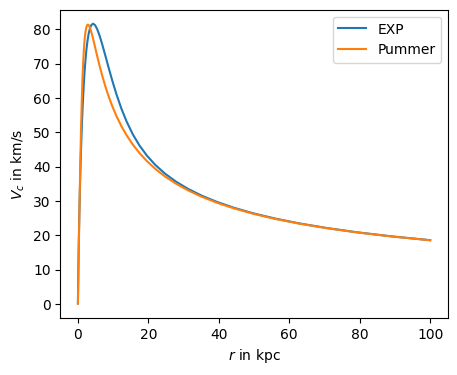

In [34]:
fig,ax = plt.subplots(figsize = (5,4))
r = np.logspace(-3,2, 100)
ax.plot(r, pp.v_exp(np.log10(8)+9,2,r),label = 'EXP')
ax.plot(r, v_plummer(np.log10(8)+9,2,r),label = 'Pummer')
ax.legend()
ax.set_xlabel('$r$ in kpc')
ax.set_ylabel('$V_c$ in km/s')
# ax.text(60,50, 'M = 8 x 1e9 Msun\nb = 2 kpc')
# plt.savefig('../Output/figures/Bulge_comparion.png',bbox_inches = 'tight',dpi = 300)

# LSR dependence of RC of PB14

In [15]:
mw = np.loadtxt('../Accessory/mw1.dat')

In [16]:
Rsun,Vsun = 8.5, 220.
indx = np.where(mw[:,0] == Rsun)[0]
r,v = mw[:,2][indx], mw[:,3][indx]

Rsun_new, Vsun_new = 8.3, 244.
indx2 = np.where(mw[:,0] == Rsun_new)[0]
r_, v_ = mw[:,2][indx2], mw[:,3][indx2]

v_new = (Rsun/Rsun_new)*(v - (r_/Rsun)*(Vsun - Vsun_new))
r_new = r_

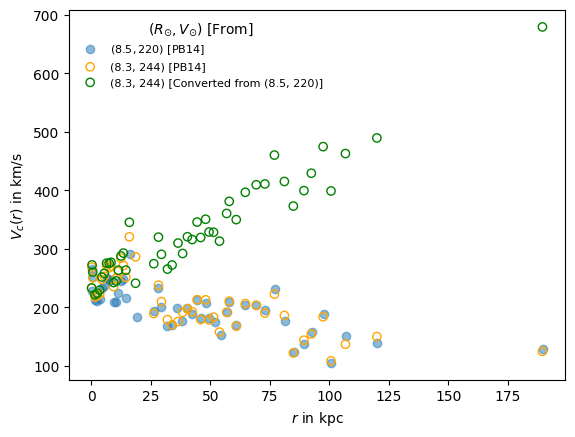

In [19]:
fig,ax = plt.subplots()
ax.scatter(r,v,label = '$(8.5, 220)$ [PB14]',alpha = 0.5)
ax.scatter(r_,v_,facecolor = 'none',edgecolor = 'orange', label = '(8.3, 244) [PB14]')
ax.scatter(r_new, v_new, facecolor = 'none',edgecolor = 'green',label = '(8.3, 244) [Converted from (8.5, 220)]')
ax.legend(title = '$(R_{\odot}, V_{\odot})$ [From]',prop = {'size':8},framealpha = 0)
# ax.set_xlim(0,10)
# ax.text(0.01, 0.9,r'$\tilde{V}_{c}(r) = \frac{R_\odot}{\tilde{R}_\odot} [V_c(r) - \frac{r}{R_\odot}(V_\odot - \tilde{V}_\odot)]$',transform = ax.transAxes)
ax.set_xlabel('$r$ in kpc')
ax.set_ylabel('$V_c(r)$ in km/s')
plt.savefig('../Output/figures/PB_eq9_GC_conversion_2.pdf',bbox_inches = 'tight',dpi = 300)

# 2 disc $\rightarrow$ 1 disc approximation

In [42]:
result = np.load('../Output/Ultra/MW_RC_fit/MW_fit_results.npy', allow_pickle = True)[()]
m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = result['posterior']['mean']
r = np.logspace(-1,np.log10(210),len(mw_r))
vdark_2d = pp.v_nfw(np.log10(m200)+12.,pp.rs_nfw(np.log10(m200)+12.,c200),r)
vgas_2d = pp.v_exp(np.log10(mdgas)+9.,rdgas,r)
vbul_2d = pp.v_exp(np.log10(mdbul)+9.,rdbul,r)
vthin_2d = pp.v_exp(np.log10(34.8)+9.,2.53,r)
vthic_2d = pp.v_exp(np.log10(11.2)+9.,3.38,r)
vc_2d = np.sqrt(vdark_2d**2 + vgas_2d**2 + vbul_2d**2 + vthin_2d**2 + vthic_2d**2)
ve_2d = vc_2d*0.05
r_2d = r

In [37]:
def llike_2d(params):
    if params[7] < params[5]:
        return -1e38
    if params[6] > params[5]:
        return -1e38
    if (params[2] < params[3]) or (params[2] < params[4]):
        return -1e38
    vmodel = RCmodel(params,bulge='EXP',r = r_2d)
    indx = np.where((mw_r >= 0))
    ll = -0.5*(((vc_2d[indx] - vmodel[indx])/(ve_2d[indx]))**2).sum()
    ll -= ((np.log10(params[1]) - pp.lc200_SR(np.log10(params[0])+12.0))/0.11)**2
    return ll

In [38]:
ultraroot = '../Output/Ultra/MW_2disc_approximation'
nsteps = 2*len(param_names)
sampler_2d = ultranest.ReactiveNestedSampler(param_names, llike_2d, prior,
                                          log_dir = ultraroot, 
                                          resume = 'resume')
sampler_2d.stepsampler = ultrastep.RegionSliceSampler(nsteps = nsteps)
result_2d = sampler_2d.run()

[ultranest] Resuming from 5075 stored points
[ultranest] Widening roots to 615 live points (have 400 already) ...
[ultranest] Widening roots to 950 live points (have 615 already) ...


[ultranest] Explored until L=-0.2   [-0.9245..-0.9237]*| it/evals=10488/466861 eff=2.9614% N=400     0   
[ultranest] Likelihood function evaluations: 467069
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -21.84 +- 0.1953
[ultranest] Effective samples strategy satisfied (ESS = 2599.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.


----- Thin disc -----
Mdstar = 34.8 x 1e9 Msun
Rdstar = 2.53 kpc

----- Thick disc -----
Mdstar = 11.2 x 1e9 Msun
Rdstar = 3.38 kpc

--- Fit results 1-disc -----
Mdstar = 63.0 x 1e9 Msun
Rdstar = 3.12 kpc



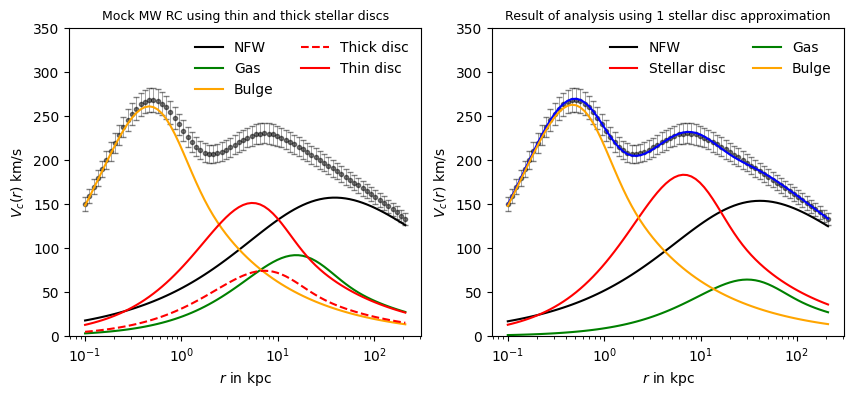

In [66]:
print ('----- Thin disc -----')
print ('Mdstar = 34.8 x 1e9 Msun')
print ('Rdstar = 2.53 kpc')
print ('\n----- Thick disc -----')
print ('Mdstar = 11.2 x 1e9 Msun')
print ('Rdstar = 3.38 kpc')
print ('\n--- Fit results 1-disc -----')
print (f'Mdstar = {params_2d[2]:.1f} x 1e9 Msun')
print (f'Rdstar = {params_2d[5]:.2f} kpc\n')

fig,axs = plt.subplots(1,2,figsize = (10,4))
ax1,ax2 = axs
for ax in axs:
    ax.errorbar(r_2d, vc_2d, ve_2d, color = 'k', fmt = '.', capsize = 2, elinewidth = 0.5,alpha = 0.5,zorder = 0)
    ax.set_xscale('log')
    ax.set_ylim(0,350)
    ax.set_xlabel('$r$ in kpc')
    ax.set_ylabel('$V_c(r)$ km/s')

ax1.plot(r_2d,vdark_2d,c = 'k',label = 'NFW')
ax1.plot(r_2d,vgas_2d,c = 'g',label = 'Gas')
ax1.plot(r_2d,vbul_2d,c = 'orange',label = 'Bulge')
ax1.plot(r_2d,vthic_2d,c = 'r',ls = '--',label = 'Thick disc')
ax1.plot(r_2d,vthin_2d,c = 'r',ls = '-',label = 'Thin disc')
ax1.legend(framealpha = 0,loc = 'upper right',ncol = 2)
ax1.set_title('Mock MW RC using thin and thick stellar discs',size = 9)

params_2d = result_2d['posterior']['mean']
vmodel,vnfw,vstar,vgas,vbul = RCmodel(params_2d,r = r_2d, output = 'all')
ax2.plot(r_2d,vmodel,c = 'b',zorder = 1)
ax2.plot(r_2d,vnfw,c = 'k',label = 'NFW')
ax2.plot(r_2d,vstar,c = 'r',label = 'Stellar disc')
ax2.plot(r_2d,vgas,c = 'g',label = 'Gas')
ax2.plot(r_2d,vbul,c = 'orange',label = 'Bulge')
ax2.legend(framealpha = 0,ncol = 2)
ax2.set_title('Result of analysis using 1 stellar disc approximation',size = 9);
plt.savefig('../Output/figures/MW_2disc_approximation.png',bbox_inches = 'tight',dpi = 300)

# $\Delta m_{MW}$ from MCMC chains of the above MW RC analysis using Ultranest

In [ ]:
from project.energetics import EI_vdf as EI
import math
from scipy.signal import medfilt
from tqdm.notebook import tqdm

def VDF_MW(params, r = 8, n = 100):
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = params
    rs = pp.rs_nfw(np.log10(m200)+12., c200)
    model = {'dm':['NFW',np.log10(m200)+12.,rs]}
    model['disk'] = ['EXP',np.log10(mdstar)+9.,rdstar]
    model['gas'] = ['EXP',np.log10(mdgas)+9.,rdgas]
    model['bulge'] = ['EXP',np.log10(mdbul)+9.,rdbul]

    ei = EI(model)
    vdf = ei.get_vdf(r,n)
    vesc = ei.Vmax(r)
    v,vdf = vdf[:,0],vdf[:,1]
    vdf = medfilt(vdf, kernel_size = 5)
    vdf = sp.interpolate.interp1d(v,vdf,kind = 'cubic',
                                  fill_value = 0,
                                  bounds_error = False)(v)
    return (v,vdf,vesc)

norm = lambda x,y: y/np.trapz(y,x)

chain_root = '../Output/Ultra/MW_RC_fit/MW_fit_results.npy'
data = np.load(chain_root,allow_pickle = True)[()]
samp = data['samples']
sampN = len(samp[:,0])
stepN = math.floor(float(sampN)/1000.)
if stepN < 1: stepN = 1
    
vdf_chain = []
for i in tqdm(range(0,sampN,stepN)):
    params_ = samp[i]
    vdf_ = VDF_MW(params_)
    vdf_chain.append(vdf_)

  0%|          | 0/1016 [00:00<?, ?it/s]

In [70]:
MW_dict.keys()

dict_keys(['fiducial_range', 'massmodels', 'VDFs', 'Vescs', 'v', 'vdf_16_84', 'vdf_05_95', 'RC'])

In [11]:
# pickle.dump(vdf_chain, open('../Output/MW_vdf_chain.pkl','wb'))
# vdf_chain = pickle.load(open('../Output/MW_vdf_chain.pkl','rb'))

MW_dict['vdf_chain'] = vdf_chain
pickle.dump(MW_dict, open('../Output/'))

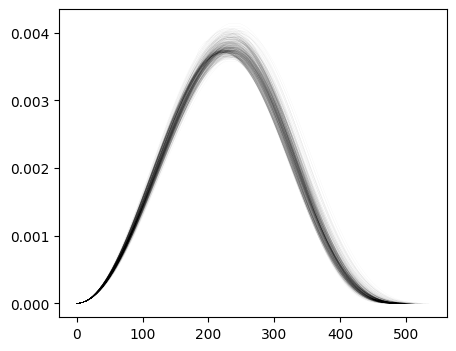

In [67]:
fig,ax = plt.subplots(figsize = (5,4))

for vdf_ in vdf_chain:
    v,vdf,vesc = vdf_
    ax.plot(v,vdf,c = 'k',lw = 0.1,alpha = 0.1)